In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import itertools

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,RobustScaler,Normalizer,MaxAbsScaler
from sklearn.model_selection import train_test_split
from airbnbCABATransformer import AirbnbCABATransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_squared_log_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Cargamos el dataset limpio 
data = pd.read_csv('data/listings.csv')
data.sample(3)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1611,6354987,https://www.airbnb.com/rooms/6354987,20220922013624,2022-09-22,city scrape,CONFORTABLE DTO EN PALERMO,Excelente departamento ubicado en la zona de P...,El barrio de Palermo es un lugar privilegiado ...,https://a0.muscache.com/pictures/83329579/912d...,33106905,...,4.91,4.82,4.82,NaN,f,4,4,0,0,0.12
4809,25723358,https://www.airbnb.com/rooms/25723358,20220922013624,2022-09-22,city scrape,Luminosa habitación con WC privado,Habitación con WC privado en departamento de c...,"Barrio:<br />Tranquilo, rodeado de universidad...",https://a0.muscache.com/pictures/30197725-fa59...,145886194,...,4.88,4.87,4.77,NaN,f,1,0,1,0,1.03
12754,53933077,https://www.airbnb.com/rooms/53933077,20220922013624,2022-09-22,city scrape,Cozy studio in the heart of the city. MICROCENTRO,Disfruta de la sencillez de este alojamiento t...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,436895909,...,4.42,4.68,4.32,NaN,t,4,4,0,0,3.50


In [3]:
dataclean = AirbnbCABATransformer().transform(data)
dataclean.head()

213 outliers found out of 17947 data points, 1.1868278820972864% of the data. 45077.0 is the max
18 outliers found out of 17734 data points, 0.10149994361114245% of the data. 8.0 is the max
88 outliers found out of 17716 data points, 0.4967261232783924% of the data. 8.0 is the max
331 outliers found out of 17628 data points, 1.8776945768096212% of the data. 47.0 is the max


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,...,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathroomtype_private,bathroomtype_shared
0,0,1,1,2,1,1,1,9823,3,1125,...,1,0,0,0,1,0,0,0,1,0
1,1,1,1,2,1,1,1,5687,2,730,...,1,0,0,0,1,0,0,0,1,0
2,0,1,1,2,1,1,1,3728,7,1125,...,1,0,0,0,1,0,0,0,1,0
3,1,1,1,4,2,1,1,6514,14,1125,...,1,0,0,0,1,0,0,0,1,0
4,1,1,0,2,1,1,1,3584,5,730,...,1,0,0,0,1,0,0,0,1,0


In [4]:
#Genero mi variable X
X=dataclean.drop(['price'],axis=1)

#Genero la variable y
y = dataclean['price'].squeeze()

#Creamos las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10,shuffle=True)

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=41)

In [5]:

pasos = [('preprocessor', MinMaxScaler()), 
         ('regresor', LinearRegression())]

pipe=Pipeline(pasos)



In [6]:
def make_param_grids(steps, param_grids):

    final_params=[]

    for estimator_names in itertools.product(*steps.values()):
        current_grid = {}

        for step_name, estimator_name in zip(steps.keys(), estimator_names):            
            for param, value in param_grids.get(estimator_name).items():
                if param == 'object':
                    # Set actual estimator in pipeline
                    current_grid[step_name]=[value]
                else:
                    # Set parameters corresponding to above estimator
                    current_grid[step_name+'__'+param]=value
        #Append this dictionary to final params            
        final_params.append(current_grid)

    return final_params

pipeline_steps = {'preprocessor':['ssc', 'mms','none','abs','norm','rss'],
                  'regresor':['lr', 'rf','xgb','lgb']}

# fill parameters to be searched in this dict
all_param_grids = {'lr':{'object':LinearRegression()
                         }, 

                   'rf':{'object':RandomForestRegressor(),                                                  
                        },

                   'ssc':{'object':StandardScaler()
                         },

                   'mms':{'object':MinMaxScaler()
                         },
                   'none':{'object':None
                         },
                   'xgb':{'object': xgb.XGBRegressor()                          
                         },
                   'lgb':{'object': lgb.LGBMRegressor()
                         },
                    'abs':{'object': MaxAbsScaler()                        
                          },
                   'norm':{'object': Normalizer()                        
                          },
                   'rss':{'object': RobustScaler()                        
                          }
                  }  



# Call the method on the above declared variables
param_grids_list = make_param_grids(pipeline_steps, all_param_grids)

In [7]:
param_grids_list

[{'preprocessor': [StandardScaler()], 'regresor': [LinearRegression()]},
 {'preprocessor': [StandardScaler()], 'regresor': [RandomForestRegressor()]},
 {'preprocessor': [StandardScaler()],
  'regresor': [XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=None, max_delta_step=None, max_depth=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                random_state=None, reg_alpha=None, reg_lambda=None,
                scale_pos_weight=None, subsample=None, tree_method=None,
                validate_parameters=None, verbosity=None)]},
 {'preprocessor': [StandardScaler()], 'regresor': [LGBMRegressor()]},
 {'preprocessor': [MinMaxScaler()], 'regresor': [LinearRegression()]},
 {'pr

In [8]:
grid=GridSearchCV(pipe, param_grid = param_grids_list, cv=folds,verbose=1, n_jobs=-1)
    
grid.fit(X_train,y_train.squeeze())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor', MinMaxScaler()),
                                       ('regresor', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'preprocessor': [StandardScaler()],
                          'regresor': [LinearRegression()]},
                         {'preprocessor': [StandardScaler()],
                          'regresor': [RandomForestRegressor()]},
                         {'preprocessor': [Stand...
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=100,
                   

In [9]:
print(grid.best_estimator_)

Pipeline(steps=[('preprocessor', StandardScaler()),
                ('regresor', LGBMRegressor())])


In [10]:
grid.best_estimator_.score(X_test,y_test)

0.44580340734280777

In [11]:
y_train_grid_preds = grid.best_estimator_.predict(X_train)
y_test_grid_preds = grid.best_estimator_.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_grid_preds), mean_squared_error(y_test, y_test_grid_preds)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_grid_preds),r2_score(y_test, y_test_grid_preds)))
print('-----------------------------------------------------')


MSE train: 11997762.365, test: 18306087.630
R^2 train: 0.611, test: 0.446
-----------------------------------------------------


In [27]:
pipelgbm = Pipeline(steps=[('preprocessor', StandardScaler()),('regresor', lgb.LGBMRegressor())])

params_lgb = {  
    "regresor__n_estimators": [2000,4000,5000,6000], 
    "regresor__max_depth": [8,9,10], 
    "regresor__learning_rate": [0.005, 0.01],  
}

grid_lgb=GridSearchCV(pipelgbm, param_grid = params_lgb, cv=folds,verbose=1, n_jobs=-1)
  
grid_lgb.fit(X_train,y_train.squeeze())


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=41, shuffle=True),
             estimator=Pipeline(steps=[('regresor', LGBMRegressor())]),
             n_jobs=-1,
             param_grid={'regresor__learning_rate': [0.005, 0.01],
                         'regresor__max_depth': [8, 9, 10],
                         'regresor__n_estimators': [2000, 4000, 5000, 6000]},
             verbose=1)

In [28]:
print(grid_lgb.best_estimator_)

Pipeline(steps=[('regresor',
                 LGBMRegressor(learning_rate=0.005, max_depth=10,
                               n_estimators=4000))])


In [31]:
y_train_grid_preds = grid_lgb.best_estimator_.predict(X_train)
y_test_grid_preds = grid_lgb.best_estimator_.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_log_error(y_train, y_train_grid_preds), mean_squared_log_error(y_test, y_test_grid_preds)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_grid_preds),r2_score(y_test, y_test_grid_preds)))
print('-----------------------------------------------------')


MSE train: 0.146, test: 0.217
R^2 train: 0.669, test: 0.450
-----------------------------------------------------


/home/docker/.conda/envs/dhdsblend2021/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

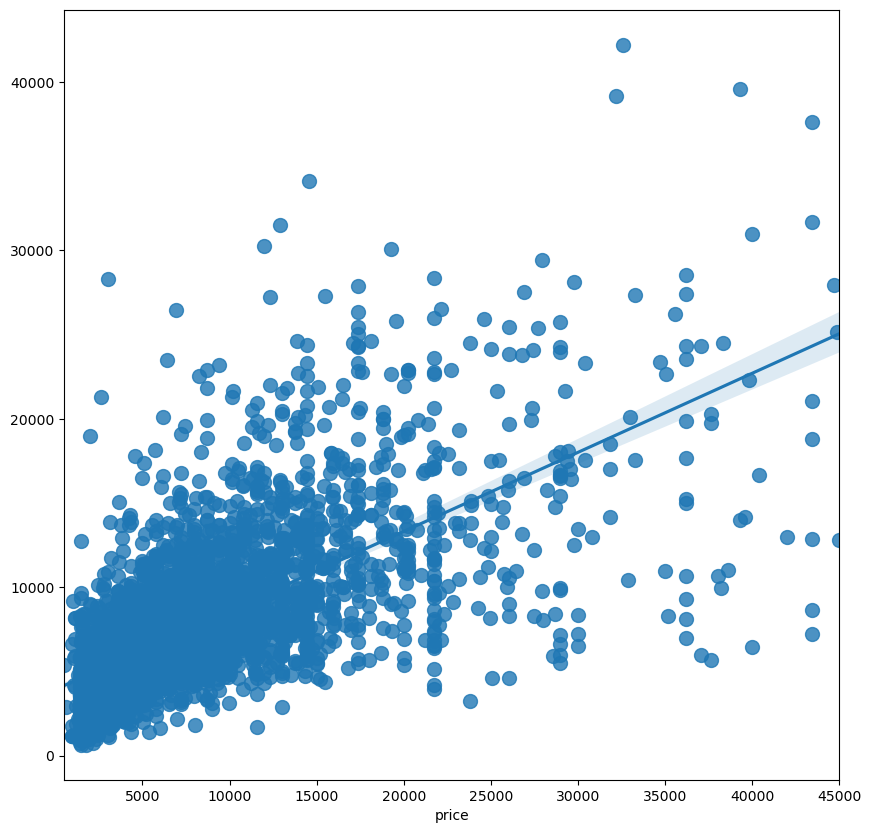

In [32]:
plt.figure(figsize=(10,10))
sns.regplot(y_test, y_test_grid_preds, fit_reg=True, scatter_kws={"s": 100})